## Package 설치


> 먼저 본 실습에 필요한 transformers를 설치 합니다.

In [1]:
!pip install transformers==4.6.1
!pip install tqdm==4.41.1

## 데이터 다운로드


> 다음은 본 실습에서 필요한 데이터 셋을 다운로드 받아 주세요.



In [2]:
!git clone https://github.com/e9t/nsmc

fatal: destination path 'nsmc' already exists and is not an empty directory.


In [3]:
!ls -l nsmc/

total 38640
drwxr-xr-x 2 root root     4096 Jun  6 02:19 code
-rw-r--r-- 1 root root  4893335 Jun  6 02:19 ratings_test.txt
-rw-r--r-- 1 root root 14628807 Jun  6 02:19 ratings_train.txt
-rw-r--r-- 1 root root 19515078 Jun  6 02:19 ratings.txt
drwxr-xr-x 2 root root   479232 Jun  6 02:19 raw
-rw-r--r-- 1 root root     2596 Jun  6 02:19 README.md
-rw-r--r-- 1 root root    36746 Jun  6 02:19 synopses.json


## Google Drive 연동 하기

> 학습이 끝나고 모델을 Google Drive에 저장 하기 위해 colab과 google drive를 연동 합니다.

In [4]:
from google.colab import drive

drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


## 파라메터(Parameters) 설정하기

> 학습에 이용할 파라메터를 설정 합니다. 이번 실습에서 설정한 파라메터는 다음과 같습니다.

In [5]:
args = {
    'train_data_path': './nsmc/ratings_train.txt',
    'val_data_path': './nsmc/ratings_test.txt',
    'save_path': '/content/gdrive/MyDrive/huggingface_model',
    'max_epochs': 1,
    'model_path': 'beomi/KcELECTRA-base',
    'batch_size': 32,
    'learning_rate': 5e-5,
    'warmup_ratio': 0.0,
    'max_seq_len': 128,
    'random_seed': 42,
}

재현을 위해 `random_seed`값을 설정 합니다.

In [6]:
import random
import numpy as np
import torch

def set_seed(random_seed):
    random.seed(random_seed)
    np.random.seed(random_seed)
    torch.manual_seed(random_seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(random_seed)

set_seed(args['random_seed'])

## Torch Dataset

> 다운로드 받은 nsmc 데이터로부터 학습 데이터를 만들기 위해 Pytorch Dataset을 만들어 줍니다. 별도의 전처리 작업은 진행하지 않고 `max_length` 까지의 문자열만 사용 하였습니다.



In [7]:
import pandas as pd
import torch

from torch.utils.data import Dataset

class NSMCDataset(Dataset):
    def __init__(self, csv_file, tokenizer, max_length):
        df = pd.read_csv(csv_file, sep='\t')
        # NaN 값 제거
        df = df.dropna(axis=0)
        # 중복 제거
        df.drop_duplicates(subset=['document'], inplace=True)
        self.input_ids = tokenizer.batch_encode_plus(
            df['document'].to_list(),
            padding='max_length',
            max_length=max_length,
            return_tensors='pt',
            return_token_type_ids=False,
            return_attention_mask=False,
            truncation=True,
        )['input_ids']
        self.labels = torch.LongTensor(df['label'])

    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, idx):
        return self.input_ids[idx], self.labels[idx]

## Model 및 Tokenizer 불러오기

> 학습에 사용할 모델과 Tokenizer 파일을 Huggingface에서 불러옵니다.

In [8]:
from transformers import ElectraForSequenceClassification, ElectraTokenizerFast

model = ElectraForSequenceClassification.from_pretrained(args['model_path'])
tokenizer = ElectraTokenizerFast.from_pretrained(args['model_path'])

Some weights of the model checkpoint at beomi/KcELECTRA-base were not used when initializing ElectraForSequenceClassification: ['discriminator_predictions.dense.weight', 'discriminator_predictions.dense_prediction.weight', 'discriminator_predictions.dense.bias', 'discriminator_predictions.dense_prediction.bias']
- This IS expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at beomi/KcELECTRA-base and are newly initialized: ['classifier.dense.bias', 'classifier.ou

## 학습


> 모델을 학습합니다. 학습에 사용할 파라메터는 `args`에서 정의 하였습니다.



In [9]:
from transformers import AdamW, get_linear_schedule_with_warmup
from tqdm.notebook import tqdm

def train(model, train_dataloader, args):
    model.train()
    model.to('cuda')
    global_total_step = len(train_dataloader) * args['max_epochs']
    global_step = 0
    optimizer = AdamW(model.parameters(), lr=args['learning_rate'], weight_decay=0.0)
    scheduler = get_linear_schedule_with_warmup(optimizer,
                                                num_warmup_steps=0,
                                                num_training_steps=global_total_step)
    with tqdm(total=global_total_step, unit='step') as t:
        total = 0
        total_loss = 0
        total_correct = 0
        for epoch in range(args['max_epochs']):
            for batch in train_dataloader:
                global_step += 1
                b_input_ids = batch[0].to('cuda', non_blocking=True)
                b_labels = batch[1].to('cuda', non_blocking=True)
                model.zero_grad(set_to_none=True)
                outputs = model(
                    input_ids=b_input_ids,
                    labels=b_labels
                )
                loss, logits = (outputs['loss'], outputs['logits']) if isinstance(outputs, dict) else (
                    outputs[0], outputs[1])

                loss.backward()
                optimizer.step()
                scheduler.step()

                preds = logits.detach().argmax(dim=-1).cpu().numpy()
                out_label_ids = b_labels.detach().cpu().numpy()
                total_correct += (preds == out_label_ids).sum()

                batch_loss = loss.item() * len(b_input_ids)

                total += len(b_input_ids)
                total_loss += batch_loss

                t.set_postfix(loss='{:.6f}'.format(batch_loss),
                              accuracy='{:.2f}'.format(total_correct / total * 100))
                t.update(1)
                del b_input_ids
                del outputs
                del loss

In [10]:
 from torch.utils.data import DataLoader

train_data_set = NSMCDataset(args['train_data_path'], tokenizer, args['max_seq_len'])
train_data_loader = DataLoader(
    dataset=train_data_set,
    batch_size=args['batch_size'],
    pin_memory=True,
    shuffle=True,
    )

In [11]:
train(model, train_data_loader, args)

## Smaple Data 넣어 보기



> 학습한 모델에 몇가지 데이터를 넣어서 확인해보겠습니다.

In [12]:
# 평점 10
pos_text = '이방원을 다룬 드라마중 최고였다고 자부함. 진짜 이방원을 보여준 듯이 연기와 인물묘사나 주변상황이 재밌었고 스토리도 진부하지 않았음. 다시 이런드라마를 볼수 있을지~ 진짜 이런 드라마하나 또 나왔음 함.'
# 평점 0
neg_text = '핵노잼 후기보고 낙였네 방금보고왔는데 개실망 재미없어요'

In [15]:
pos_input_vector = tokenizer.encode(pos_text, return_tensors='pt').to('cuda')
neg_input_vector = tokenizer.encode(neg_text, return_tensors='pt').to('cuda')

In [16]:
pos_pred = model(input_ids=pos_input_vector, labels=None).logits.argmax(dim=-1).tolist()
neg_pred = model(input_ids=neg_input_vector, labels=None).logits.argmax(dim=-1).tolist()

In [17]:
print(f'{pos_text} : {pos_pred[0]}')
print(f'{neg_text} : {neg_pred[0]}')

이방원을 다룬 드라마중 최고였다고 자부함. 진짜 이방원을 보여준 듯이 연기와 인물묘사나 주변상황이 재밌었고 스토리도 진부하지 않았음. 다시 이런드라마를 볼수 있을지~ 진짜 이런 드라마하나 또 나왔음 함. : 1
핵노잼 후기보고 낙였네 방금보고왔는데 개실망 재미없어요 : 0


In [18]:
# 허깅페이스 모델에 맞게 저장 합니다.
model.save_pretrained(args['save_path'])  

## 구글 드라이브에 저장된 모델 확인

> 모델을 저장 했으면 아래와 같이 자신이 설정한 곳으로 저장이 되어 있을 것 입니다. 현재는 간단하게 구글 드라이브에 저장을 했지만, 실제로 MLOps Pipeline 을 만들게 되면 다르게 저장해야 할 것 입니다.


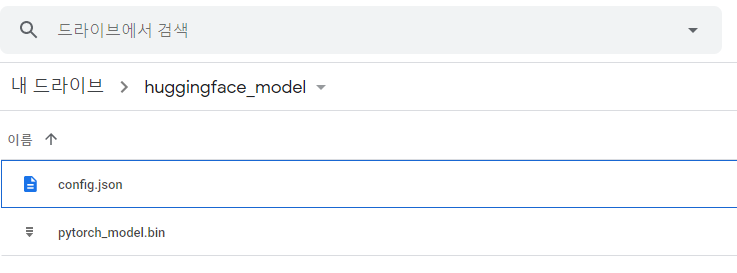

## 파라메터 튜닝 하기

> 해당 코드에서는 별도의 최적화를 하지 않았습니다. 이제 다양한 방법으로 최적화를 진행하며 여러분의 목적에 맞는 파라메터를 찾아 보세요. 추천 드리는 파라메터는 아래와 같습니다.

* 모델 : beomi/kcbert-base, beomi/kcbert-large...
* 학습률(Learning Rate) : 5e-5, 1e-5, 5e-6, 1e-6...
* 전처리 : nlpretext, soynlp...


